#Load and Explore the Dataset

In [8]:
import pandas as pd
from io import StringIO, BytesIO
import requests
from zipfile import ZipFile

# Download the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad status codes

# Read the zipped content into BytesIO
zip_content = BytesIO(response.content)

# Open the zip file from the byte stream
try:
    with ZipFile(zip_content, 'r') as zip_file:
        file_name = "SMSSpamCollection"
        with zip_file.open(file_name, 'r') as file:
            data = file.read().decode('utf-8')
except BadZipFile as e:
    print(f"Error opening zip file: {e}")
    exit()



In [9]:
# Load the dataset
df = pd.read_csv(StringIO(data), sep='\t', header=None, names=['label', 'message'])
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [11]:
# Check class balance
class_balance = df['label'].value_counts()
class_balance

,count
label,
ham,4825
spam,747


#Text Preprocessing

######Step 1: Import Necessary Libraries

In [14]:
import string         # For working with punctuation
import nltk           # Natural Language Toolkit, for text processing tasks
from nltk.corpus import stopwords  # A list of common English words to remove
from nltk.stem import WordNetLemmatizer # To reduce words to their base form
import re             # For using regular expressions to remove patterns

#####Step 2: Download NLTK Resources

In [15]:
# Download necessary NLTK resources if you haven't already
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer().lemmatize('running')
except LookupError:
    nltk.download('wordnet')
    nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


#####Step 3: Initialize Lemmatizer and Stopwords Set

In [16]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

#####Step 4: Define the Text Preprocessing Function

In [19]:
def preprocess_text(text):
  #lowercase the text
  text = text.lower()

  #remove punctuation and special characters
  text = re.sub(r'[^\w\s]','',text)

  #Tokenize the text
  words = text.split()

  #remove stopwords and lemmatize
  words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

  #join the preprocessed words back into a string
  return " ".join(words)

#####Step 5: Apply the Preprocessing to the DataFrame

In [20]:
# Apply the preprocessing to the 'message' column
df['processed_message'] = df['message'].apply(preprocess_text)

In [24]:
df[['message','processed_message']].head()

,message,processed_message
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


#3. Convert Text to TF-IDF Features

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

#####Initialize and Fit the Vectorizer

In [26]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer to the processed messages
tfidf_vectorizer.fit(df['processed_message'])

TfidfVectorizer()

#####Transform the Text Messages

In [28]:
# Transform the processed messages into TF-IDF features
tfidf_features = tfidf_vectorizer.transform(df['processed_message'])

In [30]:
# The result is a sparse matrix
tfidf_features.shape

(5572, 8893)

#4. Train the Random Forest Classifier

In [39]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = tfidf_features
y = df['label']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#Evaluate the Model

In [42]:
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

print("Predictions on the test set (first 10):\n", y_pred[:10])
print("\nActual labels of the test set (first 10):\n", y_test[:10].values)

Predictions on the test set (first 10):
 ['ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham']

Actual labels of the test set (first 10):
 ['ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham' 'ham']


In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate Precision
precision = precision_score(y_test, y_pred, pos_label='spam')
print(f"Precision: {precision:.4f}")

# Calculate Recall
recall = recall_score(y_test, y_pred, pos_label='spam')
print(f"Recall: {recall:.4f}")

# Calculate F1-Score
f1 = f1_score(y_test, y_pred, pos_label='spam')
print(f"F1-Score: {f1:.4f}")

Precision: 1.0000
Recall: 0.8591
F1-Score: 0.9242


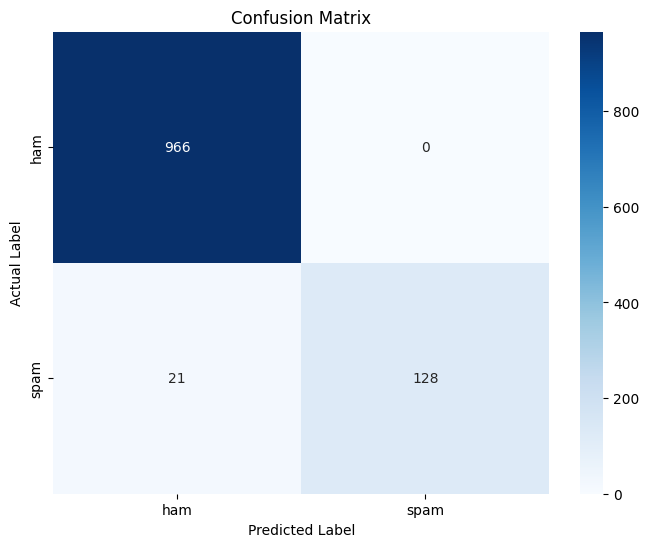

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()